# Getting started

Welcome to the absolute beginner's guide to py-fatigue! If you have comments or suggestions, please don't hesitate to file an issue or make a pull request on our GitHub repo: **[py-fatigue GitHub](https://github.com/OWI-Lab/py_fatigue/)**.

## Welcome to py-fatigue!

py-fatigue was originally part of the DYNAwind suite of tools for wind turbine structural health monitoring and analysis. The tool has been detached from the project and now relies on the following PyPi packages only:

- **Python** ([3.8, 3.9, 3.10], 64-bit)
- numpy
- plotly
- pandas
- numba vers. <0.57 (next year we will update to the latest version, but for now, we are stuck with this one, as it is the last one compatible with Python 3.8)
- matplotlib
- pydantic

The package bundles the main functionality for performing cyclic stress (fatigue and crack growth) analysis and cycle-counting.

## Installing py-fatigue

py-fatigue is freely available on GitHub and gets maintained through CI/CD philosophy. The package requires Python 3.8 or higher, and it requires a 64-bit version of Python.

To install the toolbox, simply run:

```bash
pip install py-fatigue
```


<div class="alert alert-block alert-info" style="border-radius: 6px;" role="alert">
  <div>
    ℹ️&nbsp;&nbsp;&nbsp;This notebook also uses the packages <tt>jsbeautifier</tt> and <tt>rich</tt> which are not required by <tt>py-fatigue<tt>, but they're useful to prettify print outputs our example.
  </div>
</div>


## How to import py-fatigue

To access py-fatigue's main classes (`CycleCount`, `ParisCurve`, `SNCurve`) it in your Python code like this:

In [2]:
import py_fatigue as pf

## How to use py-fatigue

The main functionality of py-fatigue is to perform cyclic stress analysis and cycle counting. The toolbox provides a number of functions to perform these tasks. The main functions are:

1. **cycle_count**: Collects all the functions related to cycle-counting fatigue data and allows a simpler representation of a rainflow-counted stress vs. time history.
2. **mean_stress**: Implements multiple mean stress correction methods, such as:
   - DNVGL-RP-C203
   - Walker
   - Smith-Watson-Topper
   - Generalized Goodman (and all its variants)
3. **material**: Allows the definition of some fatigue-specific material properties such as:
   - SN curve
   - Paris' law
4. **geometry**: Enables the instantiation of specific crack geometries for crack propagation analysis, i.e.
   - Infinite surface.
   - Hollow cylinder with a crack on its external surface.
5. **damage**: The module collecting the fatigue life calculation models.
   - **stress_life**: Fatigue analysis based on cycle-counting and SN curve.
   - **crack_growth**: Crack propagation (growth) analysis based on cycle-counting, Paris' law, and the geometrical definition of a crack case (defect geometry and medium).


## Example

In the following example, starting from a randomly generated signal, we will:

<div class="alert alert-block alert-info" style="border-radius: 6px;" role="alert">
  <div>
    ℹ️&nbsp;&nbsp;&nbsp;The following example is a simple demonstration of the py-fatigue capabilities. In a real-world scenario, the stress signal would be measured, and the cycle-counting would be performed on the measured signal.
  </div>
</div>

### Steps

- Generate a random stress signal
- Calculate the rainflow
- Export the cycle-count matrix
- Reconstruct the CycleCount object from the exported matrix
- Define a mean stress-corrected CycleCount object 
- Define the SN curve
- Calculate the Palmgren-Miner damage for the original and mean stress-corrected CycleCount objects
- Define the Paris' law
- Define a crack geometry
- Run a crack growth analysis for the original and mean stress-corrected CycleCount objects



We are going to use [`matplotlib`](https://matplotlib.org/) for visualization, and set some default parameters for the plots. For printing JSON dictionaries, we are going to use the `jsbeautifier`  and `rich` packages which are alraedy installed in the environment. Addiitonally, we are going to use [`numpy`](https://numpy.org/) for some calculations.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rich
import jsbeautifier

# matplotlib tweaking

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams["font.family"] = ["monospace"]
plt.rcParams["font.size"] = 10
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.color'] = "#E4E8EE"
plt.rcParams['grid.linestyle'] = "-"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = True

# jsbeautifier options

dict_print_opts = jsbeautifier.default_options()
dict_print_opts.indent_size = 2
dict_print_opts.space_in_empty_paren = True
dict_print_opts.wrap_line_length = 80
dict_print_opts.keep_array_indentation = True
dict_print_opts.eol = "\n"

### Random signal generation

Let's start by generating a random stress signal. The functions
`py_fatigue.testing.get_sampled_time` and `py_fatigue.testing.get_random_data`,
which internally calls [`numpy.random`](https://numpy.org/doc/stable/reference/random/index.html),
will be used to generate a random signal.


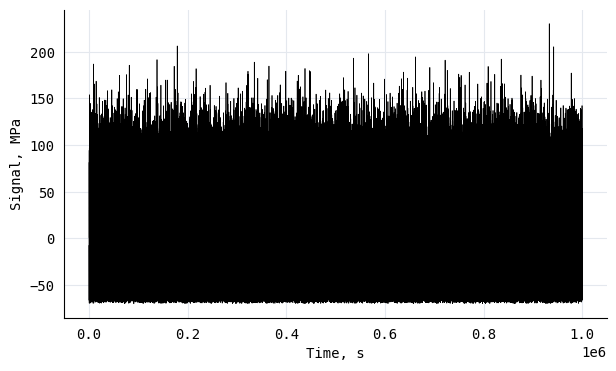

In [4]:
import py_fatigue.testing as test

# Simulate a random signal
t = test.get_sampled_time(duration=1000000, fs=1)
s = test.get_random_data(
    t=t, min_=-70, range_=300, random_type="weibull", a=2., seed=41
)

# Plot the signal
plt.plot(t, s, 'k', lw=0.5)
plt.xlabel("Time, s")
plt.ylabel("Signal, MPa")
plt.show()

### CycleCount definition

The stress signal (or time-series) is then passed to the `CycleCount` class, which will perform the cycle-counting and store it internally. The cycle-counting algorithm implemented by py-fatigue is the [ASTM Rainflow](https://cdn.standards.iteh.ai/samples/97294/04b2cc2c193541e2974bac15eb13c35a/ASTM-E1049-85-2017-.pdf).

<div class="alert alert-block alert-info" style="border-radius: 6px;" role="alert">
  <div>
    ℹ️&nbsp;&nbsp;&nbsp;There are plans to implement other cycle-counting algorithms in the future, such as:
    <ul>
      <li>ASTM Range-pair counting, from the same standard as the Rainflow algorithm.</li>
      <li>[Pavlou's algorithm](onlinelibrary.wiley.com/doi/10.1111/mice.12783)</li>
  </div>
</div>


In [5]:
# CycleCount definition
cycle_count = pf.CycleCount.from_timeseries(
    time=t, data=s, mean_bin_width=3., range_bin_width=3.,
)
cycle_count

,None
Cycle counting object,
"largest full stress range, MPa",276.139563
"largest stress range, MPa",300.0
number of full cycles,333561
number of residuals,14
number of small cycles,0
stress concentration factor,N/A
residuals resolved,False
mean stress-corrected,No


### Exporting the cycle-count matrix

The cycle-count matrix can be exported to a JSON file, which can be later imported to reconstruct the `CycleCount` object. This is useful for storing the cycle-counting results and sharing them with others.

The following options are available for exporting the cycle-count matrix:

* `legacy_export` (`bool`, optional) → If `True`, exports the cycle-count matrix in a legacy format, i.e. by disregarding mean stresses and ranges. If `False`, exports the cycle-count matrix in a more detailed format, by default `False`
* `damage_tolerance_for_binning` (`float`, optional) → Tolerance for large-cycles calculation when binning, by default 0.001
* `damage_exponent` (`float`, optional) → SN curve exponent used to define large cycles. Higher means more conservative, by default 5.0
* `max_consecutive_zeros` (`int`, optional) → maximum number of consecutive zeros before saving a cycle to large cycles array. This quantity is introduced to save storage space, by default 8
* `round_decimals` (`int`, optional) → Number of decimals after comma, by default 4
* `debug_mode` (`bool`, optional) → If `True`, prints debug information, i.e. every step of the binning process, by default `False`


In [6]:
# Exporting the cycle-count matrix in the legacy format, i.e. not 
# accounting for mean stresses. This function has been kept for
# backwards compatibility.
exp_dict_legacy = cycle_count.as_dict(max_consecutive_zeros=20,
                                      damage_tolerance_for_binning=0.2,
                                      legacy_export=True)
rich.print(jsbeautifier.beautify(str(exp_dict_legacy), dict_print_opts))

{
  'nr_small_cycles': 585,
  'range_bin_lower_bound': 0.2,
  'range_bin_width': 3.0,
  'hist': [9623.0, 9918.0, 10061.0, 10155.0, 10143.0, 10046.0, 9929.0, 10151.0,
    9858.0, 9869.0, 9752.0, 9830.0, 9594.0, 9489.0, 9313.0, 9310.0, 8836.0,
    8868.0, 8416.0, 8381.0, 8143.0, 7938.0, 7757.0, 7510.0, 7158.0, 6848.0,
    6521.0, 6408.0, 5941.0, 5756.0, 5409.0, 5208.0, 4862.0, 4670.0, 4330.0,
    4103.0, 3898.0, 3519.0, 3282.0, 3155.0, 2854.0, 2700.0, 2316.0, 2290.0,
    2064.0, 1837.0, 1712.0, 1560.0, 1362.0, 1250.0, 1126.0, 1027.0, 949.0,
    792.0, 700.0, 647.0, 565.0, 480.0, 432.0, 378.0, 327.0, 267.0, 240.0,
    194.0, 150.0, 136.0, 133.0, 94.0, 86.0, 69.0, 54.0, 39.0, 39.0, 28.0,
    25.0, 18.0, 16.0, 9.0, 8.0, 7.0, 6.0, 10.0, 5.0, 4.0, 5.0, 0.0, 3.0, 2.0,
    1.0, 1.0, 0.0, 1.0],
  'lg_c': [],
  'res': [163.4869, 223.2622, 223.3126, 256.2841, 256.8138, 300.0, 299.7304,
    274.9841, 274.8993, 211.8453, 208.3262, 183.9154, 164.8598, 61.9834],
  'res_sig': [94.0671, -69.4198, 153.8423, -69.4703, 186.8138, -70.0, 230.0, -
    69.7304, 205.2537, -69.6456, 142.1997, -66.1265, 117.7889, -47.0709,
    14.9125]
}

In [7]:
  # Exporting the cycle-count matrix
exp_dict = cycle_count.as_dict(max_consecutive_zeros=20,
                               damage_tolerance_for_binning=0.2)

rich.print(jsbeautifier.beautify(str(exp_dict), dict_print_opts))

{
  'nr_small_cycles': 585,
  'range_bin_lower_bound': 0.2,
  'range_bin_width': 3.0,
  'mean_bin_lower_bound': -64.5,
  'mean_bin_width': 3.0,
  'hist': [[0.0, 1.0], [2.0, 3.0, 1.0, 1.0], [12.0, 5.0, 6.0, 4.0, 3.0], [22.0,
    13.0, 13.0, 9.0, 5.0, 3.0, 2.0, 0.0, 1.0], [40.0, 29.0, 34.0, 22.0,
    18.0, 18.0, 17.0, 5.0, 1.0, 1.0], [56.0, 66.0, 57.0, 65.0, 36.0, 35.0,
    30.0, 24.0, 14.0, 10.0, 8.0, 6.0, 2.0], [118.0, 101.0, 83.0, 90.0, 70.0,
    70.0, 56.0, 46.0, 28.0, 25.0, 20.0, 12.0, 8.0, 0.0, 1.0], [165.0, 137.0,
    122.0, 126.0, 111.0, 116.0, 96.0, 79.0, 64.0, 42.0, 34.0, 32.0, 20.0,
    7.0, 7.0, 2.0, 1.0, 1.0], [217.0, 180.0, 159.0, 165.0, 174.0, 131.0,
    156.0, 120.0, 110.0, 91.0, 63.0, 62.0, 52.0, 33.0, 33.0, 18.0, 11.0,
    5.0, 2.0, 1.0], [258.0, 264.0, 288.0, 232.0, 224.0, 212.0, 202.0, 220.0,
    152.0, 134.0, 130.0, 126.0, 100.0, 65.0, 67.0, 47.0, 33.0, 24.0, 18.0,
    8.0, 6.0], [335.0, 342.0, 317.0, 347.0, 358.0, 333.0, 277.0, 267.0,
    235.0, 235.0, 215.0, 173.0, 163.0, 130.0, 116.0, 91.0, 76.0, 57.0, 48.0,
    23.0, 16.0, 8.0, 2.0], [392.0, 432.0, 404.0, 422.0, 358.0, 371.0, 388.0,
    366.0, 342.0, 327.0, 313.0, 281.0, 258.0, 221.0, 213.0, 192.0, 146.0,
    112.0, 103.0, 76.0, 58.0, 35.0, 24.0, 11.0, 5.0], [460.0, 480.0, 457.0,
    444.0, 444.0, 428.0, 444.0, 438.0, 441.0, 430.0, 375.0, 378.0, 354.0,
    377.0, 320.0, 280.0, 265.0, 248.0, 162.0, 143.0, 120.0, 96.0, 59.0,
    46.0, 18.0, 10.0, 8.0, 1.0], [529.0, 523.0, 529.0, 570.0, 530.0, 522.0,
    514.0, 540.0, 487.0, 518.0, 496.0, 503.0, 422.0, 493.0, 461.0, 415.0,
    338.0, 341.0, 302.0, 249.0, 227.0, 163.0, 147.0, 111.0, 76.0, 43.0,
    35.0, 14.0, 5.0], [502.0, 562.0, 569.0, 605.0, 601.0, 574.0, 550.0,
    613.0, 585.0, 549.0, 582.0, 563.0, 584.0, 535.0, 549.0, 495.0, 458.0,
    468.0, 410.0, 423.0, 360.0, 330.0, 260.0, 214.0, 186.0, 146.0, 105.0,
    73.0, 47.0, 13.0, 9.0, 2.0], [568.0, 588.0, 621.0, 622.0, 648.0, 649.0,
    614.0, 667.0, 663.0, 625.0, 653.0, 619.0, 647.0, 588.0, 647.0, 614.0,
    593.0, 564.0, 516.0, 539.0, 460.0, 430.0, 425.0, 381.0, 319.0, 267.0,
    211.0, 164.0, 103.0, 81.0, 41.0, 34.0, 8.0], [582.0, 614.0, 640.0,
    667.0, 668.0, 654.0, 664.0, 691.0, 685.0, 721.0, 725.0, 699.0, 723.0,
    671.0, 671.0, 686.0, 693.0, 723.0, 630.0, 627.0, 614.0, 599.0, 572.0,
    507.0, 482.0, 422.0, 363.0, 322.0, 248.0, 189.0, 170.0, 105.0, 63.0,
    25.0, 11.0, 4.0], [582.0, 623.0, 619.0, 612.0, 635.0, 702.0, 676.0,
    633.0, 714.0, 767.0, 765.0, 788.0, 770.0, 767.0, 741.0, 809.0, 751.0,
    773.0, 773.0, 720.0, 728.0, 708.0, 625.0, 683.0, 639.0, 544.0, 511.0,
    518.0, 449.0, 387.0, 324.0, 235.0, 201.0, 131.0, 85.0, 40.0, 27.0, 5.0,
    2.0], [587.0, 595.0, 614.0, 617.0, 669.0, 648.0, 674.0, 707.0, 679.0,
    711.0, 671.0, 735.0, 757.0, 804.0, 741.0, 816.0, 768.0, 817.0, 758.0,
    775.0, 746.0, 811.0, 796.0, 794.0, 727.0, 723.0, 672.0, 671.0, 609.0,
    547.0, 492.0, 479.0, 366.0, 296.0, 207.0, 171.0, 104.0, 44.0, 21.0,
    10.0, 1.0], [555.0, 576.0, 624.0, 634.0, 680.0, 648.0, 665.0, 701.0,
    682.0, 687.0, 704.0, 728.0, 710.0, 736.0, 699.0, 752.0, 757.0, 706.0,
    759.0, 807.0, 738.0, 815.0, 776.0, 779.0, 744.0, 752.0, 734.0, 718.0,
    711.0, 708.0, 594.0, 610.0, 539.0, 536.0, 409.0, 374.0, 297.0, 226.0,
    135.0, 54.0, 31.0, 8.0, 2.0], [505.0, 538.0, 577.0, 559.0, 587.0, 541.0,
    600.0, 612.0, 602.0, 637.0, 621.0, 648.0, 677.0, 713.0, 696.0, 726.0,
    704.0, 749.0, 709.0, 709.0, 784.0, 715.0, 798.0, 745.0, 763.0, 756.0,
    761.0, 743.0, 684.0, 722.0, 717.0, 686.0, 678.0, 654.0, 627.0, 539.0,
    483.0, 395.0, 336.0, 236.0, 171.0, 92.0, 39.0, 12.0], [450.0, 491.0,
    495.0, 487.0, 531.0, 529.0, 560.0, 593.0, 625.0, 608.0, 564.0, 593.0,
    595.0, 625.0, 642.0, 635.0, 594.0, 651.0, 635.0, 691.0, 681.0, 686.0,
    713.0, 674.0, 710.0, 707.0, 680.0, 734.0, 711.0, 689.0, 711.0, 698.0,
    706.0, 639.0, 671.0, 608.0, 597.0, 586.0, 502.0, 445.0, 385.0, 280.0,
    192.0, 122.0, 47.0, 12.0, 2.0], [417.0, 448.0, 490.0, 491.0, 492.0

### Reconstructing the CycleCount instance from the exported matrix

The exported matrix can be imported to reconstruct the `CycleCount` object. This is useful when storing the cycle-counting results in structured formats, such as cycle-counting databases.

In [8]:
cycle_count_d = pf.CycleCount.from_rainflow(exp_dict, name="Random Signal")
cycle_count_d

,Random Signal
Cycle counting object,
"largest full stress range, MPa",276.1396
"largest stress range, MPa",300.0
number of full cycles,332976
number of residuals,14
number of small cycles,585
stress concentration factor,N/A
residuals resolved,False
mean stress-corrected,No


#### Plotting the rainflow histograms

The rainflow histograms can be plotted using the `CycleCount.plot_histogram` method. From the results it is apparent how the binning process clusters the mean-range pairs into bins, hence introducing a discretization error.

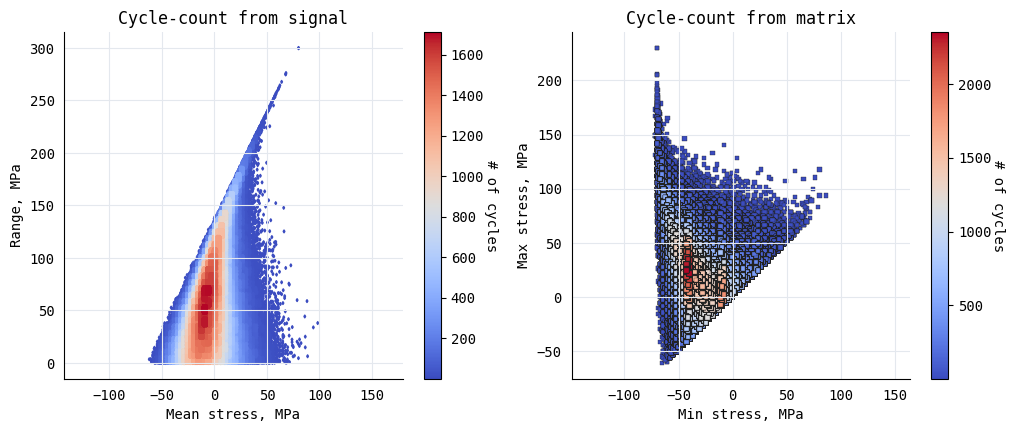

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
cycle_count.plot_histogram(fig=fig, ax=axs[0], plot_type="mean-range",
                           marker="d", s=2, cmap=mpl.colormaps["coolwarm"])
axs[0].set_title("Cycle-count from signal")
cycle_count_d.plot_histogram(fig=fig, ax=axs[1], plot_type="min-max",
                             marker="s", s=10, edgecolors="#222",
                             cmap=mpl.colormaps["coolwarm"], linewidth=0.25)
axs[1].set_title("Cycle-count from matrix")
plt.show()

### Mean stress correction

The mean stress correction is performed by the `mean_stress` module. The module implements the following mean stress correction methods:
* "DNVGL-RP-C203"
* "Walker"
* "Smith-Watson-Topper"

The mean stress correction is performed by the `CycleCount.mean_stress_correction` class method, which takes the following arguments:
* `correction_type` (`str`, optional) → Type of mean stress correction, by default "DNVGL-RP-C203"
* `plot` (`bool`, optional) → Plot the mean stress corrected history, by default `False`
* `enforce_pulsating_load` (`bool`, optional) → Choosing to enforce load ratio equals zero prior correction (useful in legacy analyses), by default `False`
* `correction_types` (`list`) → List of available correction types
* `**kwargs` (`dict`) →
  * `detail_factor` (`float`) → See DNVGL-RP-C203, by default 0.8
  * `gamma` (`float`) → See Walker mean stress correction, by default 0.5, i.e. the value for Smith-Watson-Topper correction

If mean stress correction is performed in the contest of long-term fatigue analysis, please perform the sum of multiple CycleCount instances prior mean stress correction (MSC).
In fact, applying the MSC before summing into long-term CycleCount instance results in non-conservative life estimates, as after MSC, low-frequency fatigue cannot be estimated accurately.


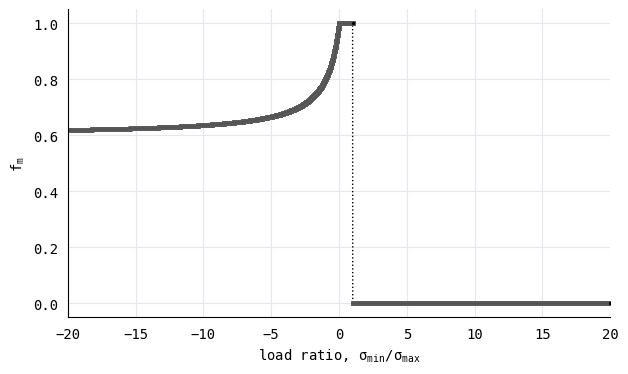

In [10]:
cycle_count_dnv_msc = cycle_count.mean_stress_correction(
  correction_type = "DNVGL-RP-C203",
  plot = True,
  detail_factor=0.6,
)


invalid value encountered in power


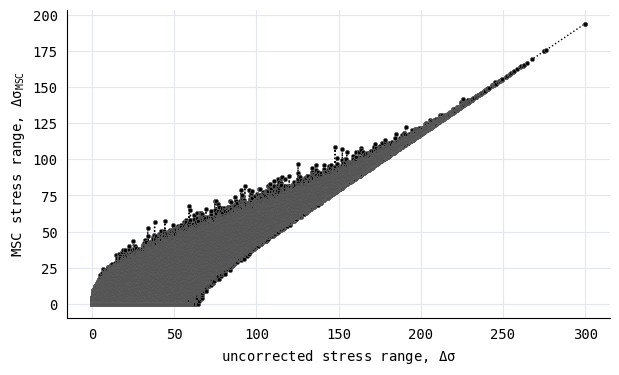

In [11]:
cycle_count_walk_msc = cycle_count.mean_stress_correction(
  correction_type = "walker",
  plot = True,
  gamma=0.4
)


In [12]:
cycle_count_haigh_msc = cycle_count.mean_stress_correction(
    "goodman",
    r_out=np.linspace(-3, 0.99, 100),
    # r_out = -1,
    ult_s=900,
    plot=True
)

cycle_count_haigh_msc

Multiple output load ratios provided!
Only the first one (r_out=-3.0) will be used in the mean stress-corrected CycleCount instance creation, while the others will be used for plotting purposes.
The number of points in the input arrays is too large for plotting. Setting plot to False to avoid matplotlib errors
If mean stress correction is performed in the contest of long-term fatigue analysis, please perform the sum of multiple CycleCount instances prior mean stress correction (MSC).
In fact, applying the MSC before summing into long-term CycleCount instance results in non-conservative life estimates, as after MSC, low-frequency fatigue cannot be estimated accurately.


,None
Cycle counting object,
"largest full stress range, MPa",325.78185
"largest stress range, MPa",362.416107
number of full cycles,333561
number of residuals,14
number of small cycles,0
stress concentration factor,N/A
residuals resolved,True
mean stress-corrected,"GOODMAN: {'r_out': array([-3. , -2.9596..."


#### Plotting the mean stress-corrected rainflow histograms

The mean stress-corrected rainflow histograms have fixed zero minimum stress value for the "DNVGL-RP-C203" correction and zero fixed mean stress value for "Walker" correction.

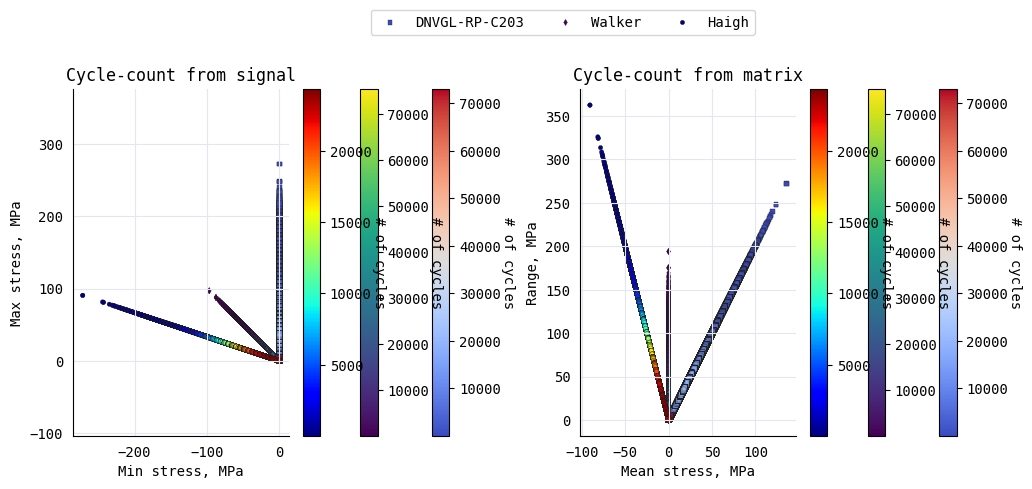

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
cycle_count_dnv_msc.plot_histogram(fig=fig, ax=axs[0], plot_type="min-max",
                                   marker="s", s=10, cmap=mpl.colormaps["coolwarm"],
                                   edgecolors="#222", linewidth=0.25,
                                   label="DNVGL-RP-C203")
cycle_count_walk_msc.plot_histogram(fig=fig, ax=axs[0], plot_type="min-max",
                                    marker="d", s=10, edgecolors="#222",
                                    cmap=mpl.colormaps["viridis"], linewidth=0.25,
                                    label="Walker")
cycle_count_haigh_msc.plot_histogram(fig=fig, ax=axs[0], plot_type="min-max",
                                     marker="o", s=10, edgecolors="#222",
                                     cmap=mpl.colormaps["jet"], linewidth=0.25,
                                     label="Haigh")
axs[0].set_title("Cycle-count from signal")
cycle_count_dnv_msc.plot_histogram(fig=fig, ax=axs[1], plot_type="mean-range",
                                   marker="s", s=10, edgecolors="#222",
                                   cmap=mpl.colormaps["coolwarm"], linewidth=0.25,
                                   label="DNVGL-RP-C203")
cycle_count_walk_msc.plot_histogram(fig=fig, ax=axs[1], plot_type="mean-range",
                                    marker="d", s=10, edgecolors="#222",
                                    cmap=mpl.colormaps["viridis"], linewidth=0.25,
                                    label="Walker")
cycle_count_haigh_msc.plot_histogram(fig=fig, ax=axs[1], plot_type="mean-range",
                                     marker="o", s=10, edgecolors="#222",
                                     cmap=mpl.colormaps["jet"], linewidth=0.25,
                                     label="Haigh")
axs[1].set_title("Cycle-count from matrix")

plt.legend(axs[0].get_legend_handles_labels()[1], bbox_to_anchor=(-1, 1.25),
           loc='upper left', ncol=3, fontsize=10)
plt.show()

## Stress-Life analysis

To perform stress=life fatigue analsis, three ingredients are needed:
1. The cycle-counted stress signal
2. The SN curve
3. The fatigue life calculation method

We have already obtained the cycle-counted stress signal in the previous steps.

### SN curve definition

The SN curve can be defined using the `material.SNCurve` class. The SN curve is defined by the following parameters:
* `slopes` (`List[float]`) → The slopes of the SN curve (they can be as many as needed).
* `intercepts` (`List[float]`) → The intercepts of the SN curve (the curve is piecewise linear in the log-log space). They are as many as the slopes.
* `fatigue_limit` (`float`) → The fatigue limit of the material, also known as the endurance limit. Below this point, the material does not fail, regardless of the number of cycles applied.

overflow encountered in scalar power
divide by zero encountered in power
overflow encountered in scalar power
invalid value encountered in scalar multiply


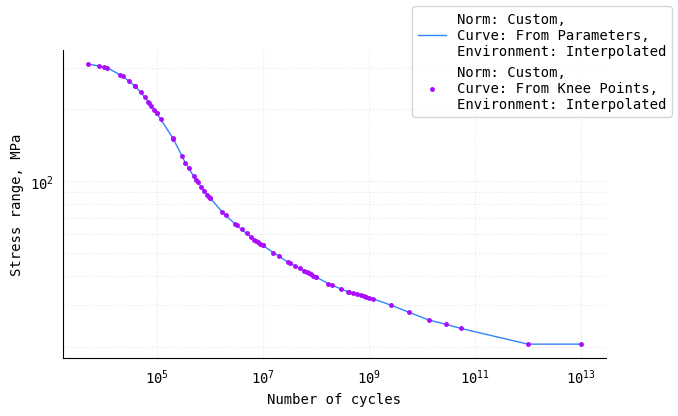

In [14]:

# A SN curve can be defined either from its knee points (this is a rather advanced
# feature), or by assigning directly its slope, intercept and endurance limit (this
# is the most common way to work with SN curves).
knee_points = """
              1, 322
             10, 321
            300, 315
          1_000, 313
          3_000, 312
          5_039, 310
          8_039, 305
         11_771, 299
         23_357, 275
         39_967, 250
         73_176, 213
        119_377, 182
        207_880, 150
        350_376, 119
        553_241, 101
        963_397,  86
      1_733_270,  74
      3_221_789,  65
      7_525_202,  56
     15_937_828,  50
     32_671_572,  45
     73_861_998,  41
    172_521_054,  37
    430_133_471,  34
  1_182_699_719,  32
  2_673_778_988,  30
  5_850_681_784,  28
 13_665_563_053,  26
 28_013_567_611,  25
 53_798_384_034,  24
121_624_268_965,  23
"""

# Convert the string data to a list of lists
knee_points_list = [list(map(float, line.split(',')))
                    for line in knee_points.strip().split('\n')]

curve_fkp = pf.SNCurve.from_knee_points(
    knee_stress=[k[1] for k in knee_points_list],
    knee_cycles=[k[0] for k in knee_points_list],
    endurance=1E12,
    norm="Custom",
    curve="From Knee Points",
    environment="Interpolated",
)

slope = curve_fkp.slope
intercept = curve_fkp.intercept
endurance = curve_fkp.endurance

sn_curve = pf.SNCurve(
    slope=slope,
    intercept=intercept,
    endurance=endurance,
    norm="Custom",
    curve="From Parameters",
    environment="Interpolated",
)

fig, ax = plt.subplots()
sn_curve.plot(fig=fig, ax=ax, lw=1)
curve_fkp.plot(fig=fig, ax=ax, marker=".", ls="", markersize=5)
fig.legend()
plt.show()

In [15]:
sn_curve.get_knee_cycles()

array([           nan,            nan,            nan,            nan,
       5.03900000e+03, 8.03900000e+03, 1.17710000e+04, 2.33570000e+04,
       3.99670000e+04, 7.31760000e+04, 1.19377000e+05, 2.07880000e+05,
       3.50376000e+05, 5.53241000e+05, 9.63397000e+05, 1.73327000e+06,
       3.22178900e+06, 7.52520200e+06, 1.59378280e+07, 3.26715720e+07,
       7.38619980e+07, 1.72521054e+08, 4.30133471e+08, 1.18269972e+09,
       2.67377899e+09, 5.85068178e+09, 1.36655631e+10, 2.80135676e+10,
       5.37983840e+10])

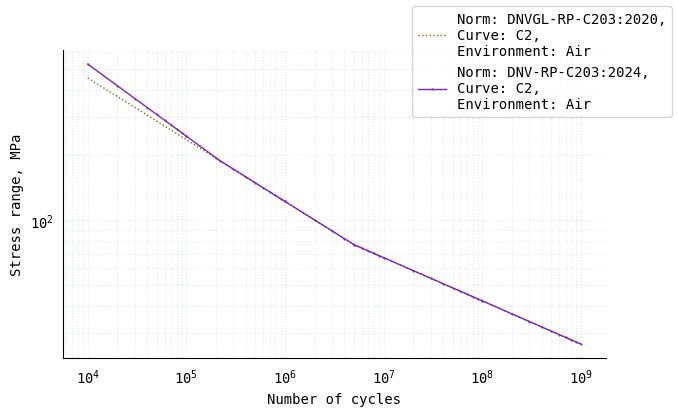

In [16]:
# from py_fatigue import SNCurve

# C_old = SNCurve(
#     slope=[3.5, 5],
#     intercept=[13.64, 16.615],
#     norm="DNV-RP-C203:2016",
#     curve="C",
#     environment="Air",
# )

# C_new = SNCurve(
#     slope=[3, 3.5, 5],
#     intercept=[12.164, 13.64, 16.615],
#     norm="DNV-RP-C203:2024",
#     curve="C",
#     environment="Air",
# )

# fig, ax = plt.subplots()
# C_old.plot(fig=fig, ax=ax, lw=1)
# C_new.plot(fig=fig, ax=ax, lw=1)
# fig.legend()


from py_fatigue import SNCurve

C2_old = SNCurve(
    slope=[3.5, 5],
    intercept=[13.301, 16.130],
    norm="DNVGL-RP-C203:2020",
    curve="C2",
    environment="Air",
)

C2_new = SNCurve(
    slope=[3, 3.5, 5],
    intercept=[12.164, 13.301, 16.130],
    norm="DNV-RP-C203:2024",
    curve="C2",
    environment="Air",
)

fig, ax = plt.subplots()
C2_old.plot(fig=fig, ax=ax, lw=1, ls=":")
C2_new.plot(fig=fig, ax=ax, lw=1, marker=".", ms=1)
fig.legend()


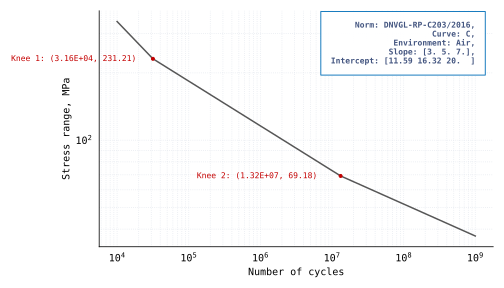

In [17]:
c_air = pf.SNCurve(
    [3, 5, 7],
    intercept=[11.592, 16.320, 20],
    endurance=float("inf"),
    norm="DNVGL-RP-C203/2016",
    environment='Air',
    curve='C'
)
c_air


### Damage calculation

The functions and classes to perform stress-life fatigue analysis are implemented in the `damage.stress_life` module. The module implements the following fatigue life calculation methods:

* Linear models
  * "Palmgren-Miner"
  * "Gassner" (linear damage rule applied that allows to treat variable amplitude loading as an equivalent constant amplitude loading applied to a shifted SN curve)
* Non-linear models
  * "Suitable for block loading"
    * "Si-Jiang"
    * "Manson-Halford"
    * "Pavlou"
    * Leve (Simply a fixed exponent is applied to every term of the Palmgren-Miner sum)
  * "Suitable for random loading"
    * "Pavlou with Damage Curve Analysis"
    * "Theil with Accumulation on SN Curve"

The simplest faigue damage equation is the Palmgren-Miner rule, which reads:

#### Linear damage rule
$$
D = \sum_{i=1}^{n} \frac{N_i}{N_{f,i}}
$$


where $D$ is the damage, $N_i$ is the number of cycles at the $i$-th stress level, and $N_{f,i}$ is the fatigue life at the $i$-th stress level.


In [18]:
# Calculate damage for the cycle-count objects
damage = pf.damage.stress_life.get_pm(cycle_count=cycle_count, sn_curve=sn_curve)
damage_d = pf.damage.stress_life.get_pm(cycle_count=cycle_count_d, sn_curve=sn_curve)
damage_h = pf.damage.stress_life.get_pm(cycle_count=cycle_count_haigh_msc, sn_curve=sn_curve)
print(f"damage from original histogram: {sum(damage)}")
print(f"damage from binned histogram:   {sum(damage_d)}")
print(f"damage from Haigh corrected histogram:   {sum(damage_h)}")


damage from original histogram: 0.26845483549518684
damage from binned histogram:   0.2685525349655838
damage from Haigh corrected histogram:   8.0129003035012445e+37


#### Non-linear damage rules

##### Block loading

The generic form of a nonlinear damage rule for block loading is:

$$
D = \left(
    \left( \dots
        \left(
            \left(
                \left(\frac{n_1}{N_1}\right)^{e_{1, 2}} +
                \frac{n_2}{N_2}
            \right)^{e_{2, 3}} +
            \frac{n_3}{N_3}
        \right)^{e_{3, 4}} + \dots + \frac{n_{M-1}}{N_{M-1}}
    \right)^{e_{M-1, M}} + \dots + \frac{n_M}{N_M}
\right)^{e_M}
$$

where $n_i$ is the number of cycles at the $i$-th stress level, $N_i$ is the fatigue life at the $i$-th stress level, and $e_{i, j}$ is the exponent between the $i$-th and $j$-th stress levels.



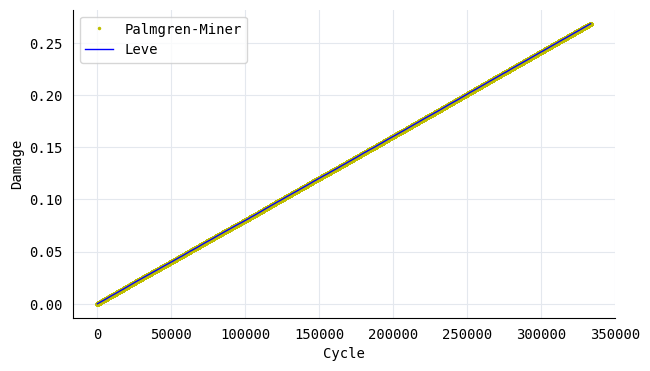

In [19]:

damage_nl_1 = pf.damage.stress_life.get_nonlinear_damage(
    damage_rule="Leve",
    cycle_count=cycle_count, sn_curve=sn_curve, base_exponent=1
)
plt.plot(np.cumsum(damage), label="Palmgren-Miner", ls="", marker=".", ms=3, c="y")
plt.plot(damage_nl_1, label="Leve", ls="-", lw=1, c="b")
plt.xlabel("Cycle")
plt.ylabel("Damage")
plt.legend()

##### Random loading (DCA)

A nonlinear damage rule for random loading is generally described by the following equations

$$
D = \sum_{j=1}^{n_b} \Delta D_j
$$

where $ n_b $ is the number of damage bands. In each damage band, the damage follows a weighted Palmgren-Miner sum, i.e.:

$$
\Delta D_j = \sum_{i=1}^{n_j} w_{i, j} \frac{n_i}{N_i}
$$

where $ n_j $ is the number of cycles in the fatigue histogram at the $ j $-th cycle, $ N_j $ is the number of cycles to failure at the $ j $-th cycle, $ w_{i, j} $ is the weight for the $ i $-th cycle in the $ j $-th damage band.

Using the generic nonlinear damage accumulation formula:

$$
D(\sigma) = \left(\frac{n}{N(\sigma)}\right)^{e(\sigma)}
$$

and substituting it inside the weighted Palmgren-Miner sum, the equation of the weights can be extracted as:

$$
w_{i, j} = \frac{D_j - D_{j-1}}{
    D_{j}^{1/e_{i, i}} - D_{j-1}^{1/e_{i, i}}
}
$$

In the case of Pavlou's model, the exponents are:

$$
e_{j, j} = \left(\frac{\Delta \sigma_j / 2}{\sigma_U}\right)^{\text{exponent}}
$$

While for Theil's method, the weights can be directly approximated as:

$$
w_j = 1 + \frac{\Delta\sigma_j}{N_{f,j}}
$$



Damage value exceeds 1 at index 333566


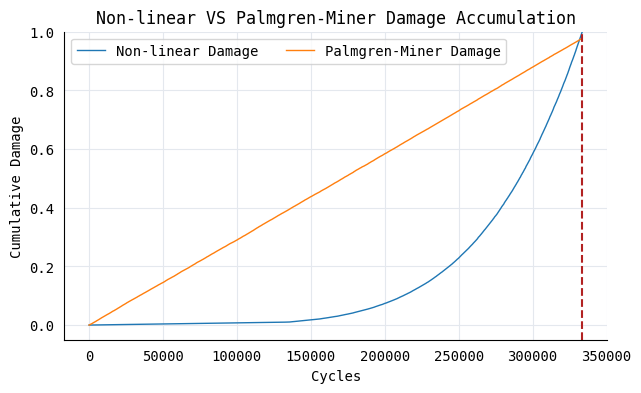

In [36]:
# Applying an artificial stress-concentration factor to the cycle-count to 
# simulate "failure" of the material
SCF = 1.5
pav_dmg, pav_dmg_cs, f_, a = pf.damage.stress_life.get_nonlinear_damage_with_dca(
    damage_rule="Pavlou",
    cycle_count=cycle_count * SCF,
    sn_curve=c_air,
    damage_bands=np.linspace(0, 1, 100),
    ultimate_stress=900,
    base_exponent=-0.75,
    plot=True
)

##### Random loading (SN curve accumulation)

Such methods suppose that the material accumulates stress internally from an initial state of zero damage. The stress and cycles accumulate towards the SN curve, identified as the limit state. When the limit state is reached, the material fails.

Mathematically, the method can be described as follows. Provided a sequence of stress range blocks $\Delta\sigma_i$ and the corresponding number of cycles $n_i$, after initializing all the cumulative variables to zero, the effective stress range is calculated as:

$$
\begin{aligned}
    N_i & = \text{SN Curve}\left(\Delta\sigma_i \right) \\
    w_i & = \frac{\Delta\sigma_i}{N_i} \\
    \Delta\sigma_{eff,i} & = \Delta\sigma_{cumsum,i-1} - w_i \cdot n_{cumsum, i-1} \\
    n_{cumsum,i} & = n_{cumsum,i-1} + n_i \\
    \Delta\sigma_{cumsum,i} & = w_i \cdot n_{cumsum,i} + \Delta\sigma_{eff,i}
\end{aligned}
$$

where:

- $\Delta\sigma_{eff}$ is the effective stress range,
- $\Delta\sigma_{cumsum}$ is the cumulative stress range,
- $w$ is the damage weight for the current cycle,
- $n_{cumsum}$ is the cumulative number of cycles,
- $n$ is the number of cycles for the current block.


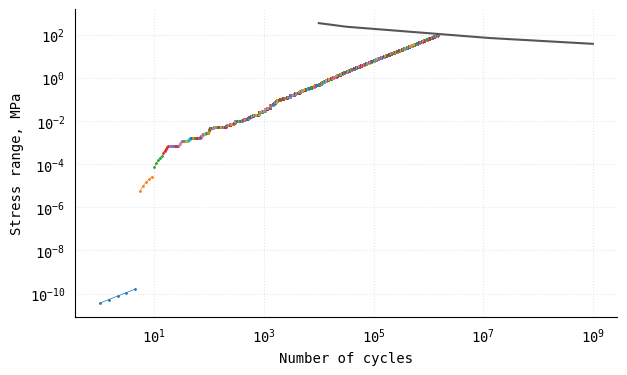

In [39]:
stress_dmg = pf.damage.stress_life.calc_theil_sn_damage(
    cycle_count.stress_range,
    cycle_count.count_cycle * SCF * 3,
    sn_curve=c_air,
    to_failure=False
)

fig, ax = plt.subplots()
for step in stress_dmg:
    plt.semilogx(step[1], step[2], ".", ls="-", lw=.5, markersize=2, label=step[0])

c_air.plot(fig=fig, ax=ax)
plt.show()


## Crack growth analysis

The crack growth analysis is performed by the `damage.crack_growth` module. The module implements a piecewise Paris' law analysis, where the crack curve is divided into segments, each with its own Paris' law parameters.

The Paris' law is defined by the following parameters:
* `C` (`float`) → The Paris' law coefficient.
* `m` (`float`) → The Paris' law exponent.

and the equation reads:

$$
\frac{da}{dN} = C \left(\Delta K\right)^m
$$

where $a$ is the crack length, $N$ is the number of cycles, and $\Delta K$ is the stress intensity factor range.

To add the effect of the mean stress, the Paris' law can be modified according to Walker's law:

$$
\frac{da}{dN} = C \left(\Delta K_{\text{eff}}\right)^m
$$

where $\Delta K_{\text{eff}}$ is the effective stress intensity factor range, calculated as:

$$
\Delta K_{\text{eff}} = \frac{\Delta K} {\left(1 - \frac{\sigma_{\text{min}}}{\sigma_{\text{max}}}\right)^{1 - \gamma}}
$$

where $\sigma_{\text{min}}$ / $\sigma_{\text{max}}=R$ are the minimum and maximum stress values, and load ratio, respectively, and $\gamma$ is the Walker's law parameter.

The term $\left(1 - R\right)^{1 - \gamma}$ is the Walker's law correction factor, which can be used to correct the intercept of the Paris' law curve as a function of the mean stress.

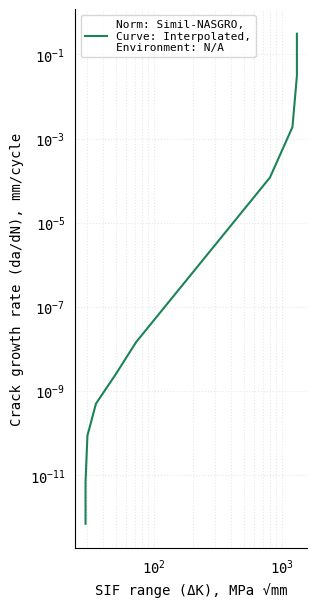

In [22]:
knee_points = """
   29, 6.93e-12
   30, 8.64e-11
   35, 4.98e-10
   50, 2.50e-9
   72, 1.44e-8
  800, 1.18e-4
1_200, 1.87e-3
1_300, 3.10e-2
"""
# Convert the string data to a list of lists
knee_points_list = [list(map(float, line.split(',')))
                    for line in knee_points.strip().split('\n')]
knee_points_list = np.array(knee_points_list)

pc = pf.ParisCurve.from_knee_points(knee_sif=knee_points_list[:,0],
                                    knee_growth_rate=knee_points_list[:,1],
                                    norm="Simil-NASGRO",
                                    environment="N/A", curve="Interpolated")
# Plotting
fig, ax = plt.subplots(figsize=(3, 7))
pc.plot(fig=fig, ax=ax)
ax.legend(prop={'size': 8})
plt.show()


### Crack geometry

The crack geometry is defined by the `geometry.` class. The class implements the following crack geometries:
* `InfiniteSurface` → An infinite surface with a crack on it.
* `HollowCylinder` → A hollow cylinder with a crack on its external surface.

Additional geometries can be added in the future.


HollowCylinder(
  _id=HOL_CYL_01,
  initial_depth=5.0,
  outer_diameter=30.0,
  thickness=10.0,
  height=30.0,
  width_to_depth_ratio=1.0,
  crack_position=external,
)

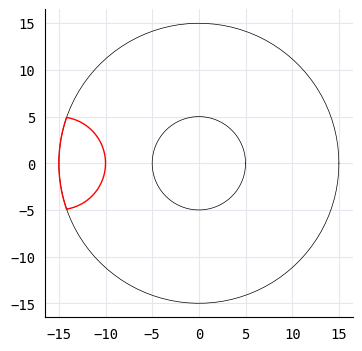

In [23]:
geo = pf.geometry.HollowCylinder(
    initial_depth=5.,
    thickness=10.,
    height=30.,
    outer_diameter=30.,
    width_to_depth_ratio=1.,
    crack_position="external"
)
geo.plot()
geo

### Running the crack growth analysis

The crack growth analysis is performed by the `damage.crack_growth` module. The module implements a piecewise Paris' law analysis, where the crack curve is divided into segments, each with its own Paris' law parameters.

At every itertion, the stress intensity factor range is calculated as:

$$
\Delta K = Y(a) \cdot \Delta \sigma \cdot \sqrt{\pi a}
$$

where $Y(a)$ is the geometry correction factor, $\Delta \sigma$ is the stress range, and $a$ is the crack length.

The crack growth is then calculated as:

$$
a_{i+1} = a_i + \frac{da}{dN} \cdot N
$$

where $a_i$ is the crack length at the $i$-th iteration, $da/dN$ is the crack growth rate calculated by the Paris' law, and $N$ is the number of cycles at the given stress level.


In [24]:
cg = pf.damage.crack_growth.get_crack_growth(
cycle_count, pc, geo, express_mode=False
)
print(f"Cycles to end: {int(cg.final_cycles)}")

Critical SIF reached. Stopping calculation.
Cycles to end: 245886


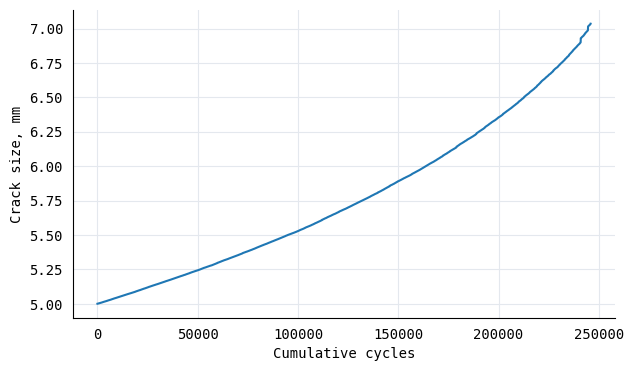

In [25]:
count_cycle = cg.count_cycle
crack_depth = cg.crack_depth

if len(crack_depth) < len(count_cycle):
    count_cycle = count_cycle[:len(crack_depth)]

plt.plot(np.cumsum(count_cycle), crack_depth)
plt.xlabel("Cumulative cycles")
plt.ylabel("Crack size, mm")
plt.show()

In [26]:
cg_d = pf.damage.crack_growth.get_crack_growth(
    cycle_count_d, pc, geo, express_mode=True
)
print(f"Cycles to end: {int(cg.final_cycles)}")

Critical SIF reached. Stopping calculation.
Cycles to end: 245886


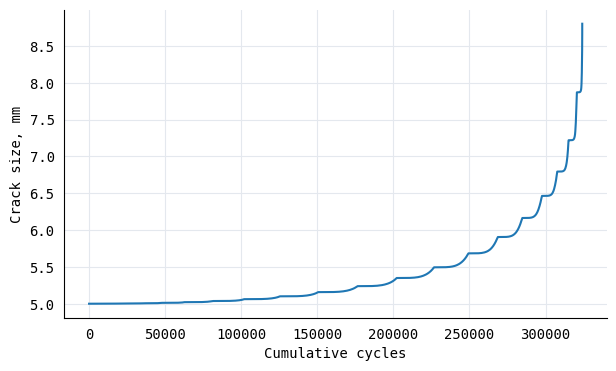

In [27]:
crack_depth = cg_d.crack_depth
count_cycle = cg_d.count_cycle

if len(crack_depth) < len(count_cycle):
    count_cycle = count_cycle[:len(crack_depth)]

plt.plot(np.cumsum(count_cycle), crack_depth)
plt.xlabel("Cumulative cycles")
plt.ylabel("Crack size, mm")
plt.show()


## Working with pandas DataFrames

It is possible to convert the cycle-counted stress signal to a pandas DataFrame using the `CycleCount.to_df` method. This is useful for further processing the data, such as exporting, or row-wise operations.

In [28]:
df = cycle_count_d.to_df()
rich.print(jsbeautifier.beautify(str(df._metadata), dict_print_opts))

{
  'name': 'Random Signal',
  'timestamp': datetime.datetime(2025, 3, 20, 13, 50, 19, 225954, tzinfo =
    datetime.timezone.utc),
  'time_sequence': array(,
    dtype = object),
  'residuals_sequence': array([94.0671, -69.4198, 153.8423, -69.4703, 186.8138,
    -70.,
       230., -69.7304, 205.2537, -69.6456, 142.1997, -66.1265,
       117.7889, -47.0709, 14.9125]),
  'mean_stress_corrected': 'No',
  'stress_concentration_factor': 1.0,
  'nr_small_cycles': 585,
  'lffd_solved': False,
  'unit': 'MPa'
}

### The Miner DataFrame Accessors

Stress-Life analysis can be performed on a pandas DataFrame using the `miner` accessor.

In [29]:
df.miner.damage(sn_curve=c_air)

,count_cycle,mean_stress,stress_range,cycles_to_failure,pm_damage
0,1.0,-63.0000,4.7000,1.973854e+15,5.066231e-16
1,2.0,-60.0000,1.7000,2.437011e+18,8.206773e-19
2,3.0,-60.0000,4.7000,1.973854e+15,1.519869e-15
3,1.0,-60.0000,7.7000,6.231103e+13,1.604852e-14
4,1.0,-60.0000,10.7000,6.227497e+12,1.605781e-13
...,...,...,...,...,...
1723,0.5,36.2771,211.8453,4.896726e+04,1.021090e-05
1724,0.5,38.0366,208.3262,5.324521e+04,9.390516e-06
1725,0.5,25.8312,183.9154,9.929092e+04,5.035707e-06
1726,0.5,35.3590,164.8598,1.715640e+05,2.914364e-06


After performing the damage calculation, the SN Curve gets attached to the DataFrame, therefore the following command is available:


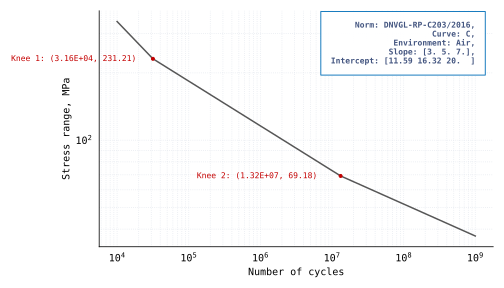

In [30]:
df.sn_curve

The Miner Histogram method shows which is the stress range / cycles combination that contributes the most to the damage through a color map.

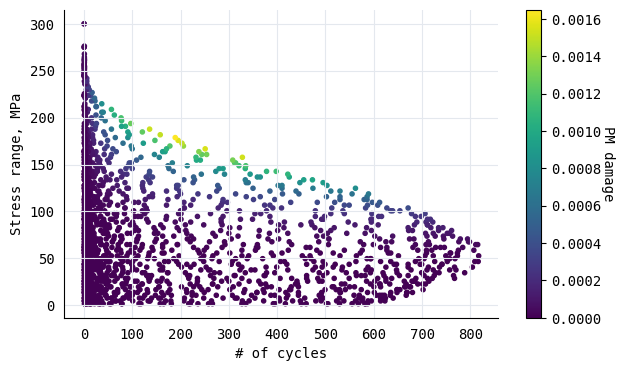

In [31]:
fig, ax = plt.subplots()
df.miner.plot_histogram(fig=fig, ax=ax)
plt.show()

### The CG DataFrame Accessors

Crack-Growth analysis can be performed on a pandas DataFrame using the `cg` accessor, which connects directly to the `damage.crack_growth` module.

In [32]:
# # TODO: Fix this
# try:
#     df.cg.calc_growth(cg_curve=pc, crack_geometry=geo)
# except AttributeError:
#     print(df)
# df.plot(kind="scatter", x="cumul_cycle", y="crack_depth", s=2)
# plt.show()

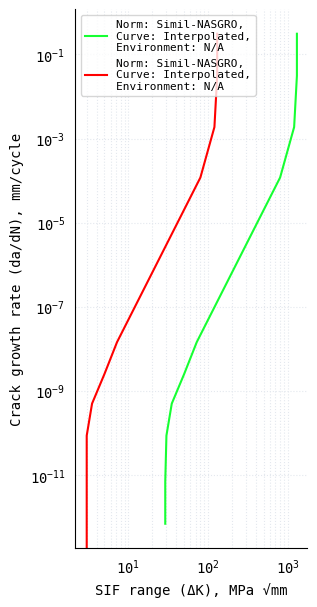

In [33]:
import copy
import py_fatigue as pf
import numpy as np
import matplotlib.pyplot as plt

knee_points = """
   29, 6.93e-12
   30, 8.64e-11
   35, 4.98e-10
   50, 2.50e-9
   72, 1.44e-8
  800, 1.18e-4
1_200, 1.87e-3
1_300, 3.10e-2
"""
# Convert the string data to a list of lists
knee_points_list = [list(map(float, line.split(',')))
                    for line in knee_points.strip().split('\n')]
knee_points_list = np.array(knee_points_list)

pc = pf.WalkerCurve.from_knee_points(knee_sif=knee_points_list[:,0],
                                     knee_growth_rate=knee_points_list[:,1],
                                     norm="Simil-NASGRO",
                                     environment="N/A", curve="Interpolated")
pc.walker_exponent = 0
pc2 = copy.copy(pc)
pc2.load_ratio = 0.9
pc2.color = "r"
# Plotting
fig, ax = plt.subplots(figsize=(3, 7))
pc.plot(fig=fig, ax=ax)
pc2.plot(fig=fig, ax=ax)
ax.legend(prop={'size': 8})
plt.show()
